In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src.models import decoders
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os

from scipy.signal import savgol_filter


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

In [17]:
torch.cuda.empty_cache() 
torch.manual_seed(42)

data_folder = np.load('Data/Data_syn_2nd_order/dataset_intensity.npy')
data_train = data_folder
print(data_train.shape)
dt = 0.2
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)




model_kld= mainmodel.EndPhys(dt = dt,  
                                pmodel = "Damped_oscillation",
                                init_phys = 1.0, 
                                initw=True)

model_kld, log, params  = train.train(model_kld, 
                                train_dataloader, 
                                test_dataloader,
                                init_phys = 1e-2,                                 
                                loss_name='latent_loss_MSE')

(500, 20, 1, 50, 50)
dt 0.2
Using device: cuda
Initial Loss 	 training loss: 0.00901147204318217 	 validation loss: 0.008893631864339113
best model a 5.477168560028076
best last a 5.477168560028076
best model b 6.692165374755859
best last b 6.692165374755859


In [18]:
data_train = data_folder
dt = 0.2
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

model =  mainmodel.EndPhys(dt = dt,  
                                pmodel = "Damped_oscillation",
                                init_phys = 1.0, 
                                initw=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.load_state_dict(torch.load('best-model-parameters.pt'))


for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = model(x0)
    z2_encoder, z2_phys, z3=outputs

    if z is None:
        z = z2_encoder.detach().cpu().numpy()[0][0]
    else:
        z = np.vstack((z,z2_encoder.detach().cpu().numpy()[0][0]))

dt 0.2


In [13]:
z_kld = z

In [19]:
z_mse = z

In [21]:
np.save('z_kld.npy', z_kld)
np.save('z_mse.npy', z_mse)

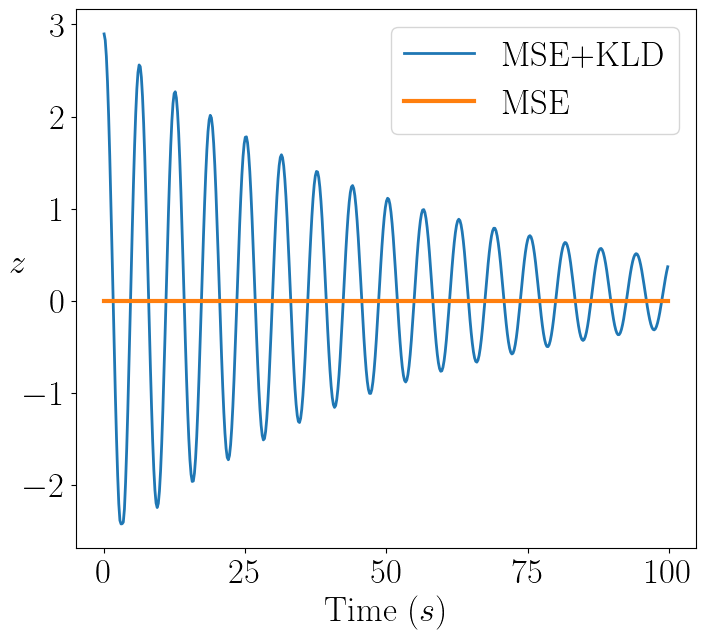

In [37]:
plt.figure(figsize=(8,7))

z_kld = np.load('z_kld.npy')
z_mse = np.load('z_mse.npy')

t_z_kld= np.arange(0, z_kld.shape[0]*dt, dt)
t_z_mse= np.arange(0, z_mse.shape[0]*dt, dt)


#set latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


#set font size
plt.rcParams.update({'font.size': 25})




plt.plot(t_z_kld,z_kld, label=r'MSE+KLD', linewidth=2 )
plt.plot(t_z_mse,z_mse, label=r'MSE', linewidth=3)
plt.xlabel(r'Time ($s$)')
plt.ylabel(r'$z$', rotation=0)
plt.legend()
plt.savefig('z_kld_vs_z_mse.pdf', dpi=300, bbox_inches='tight', format='pdf', transparent=True )
plt.show()





Epoch [50/1000], Loss: 0.0858
Epoch [100/1000], Loss: 0.0896
Epoch [150/1000], Loss: 0.0819
Epoch [200/1000], Loss: 0.0861
Epoch [250/1000], Loss: 0.0706
Epoch [300/1000], Loss: 0.0492
Epoch [350/1000], Loss: 0.0534
Epoch [400/1000], Loss: 0.0424
Epoch [450/1000], Loss: 0.0242
Epoch [500/1000], Loss: 0.0034
Epoch [550/1000], Loss: 0.0021
Epoch [600/1000], Loss: 0.0013
Epoch [650/1000], Loss: 0.0023
Epoch [700/1000], Loss: 0.0009
Epoch [750/1000], Loss: 0.0009
Epoch [800/1000], Loss: 0.0003
Epoch [850/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0002
Epoch [950/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0004


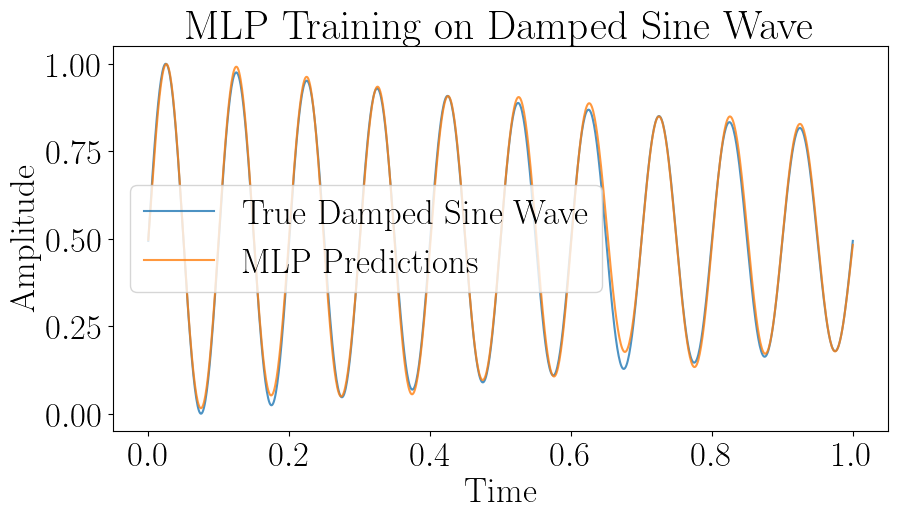

In [50]:
import torch.optim as optim

# Generate the dataset: time as input, damped sine wave as output
def generate_damped_sine_wave(t, damping_factor=0.1, frequency=2.0):
    return np.exp(-damping_factor * t) * np.sin(2 * np.pi * frequency * t)

# Dataset parameters
n_samples = 1000
time = np.linspace(0, 5, n_samples)
output = generate_damped_sine_wave(time)

# Normalize data
time = (time - time.min()) / (time.max() - time.min())  # Rescale to [0, 1]
output = (output - output.min()) / (output.max() - output.min())  # Rescale to [0, 1]

# Convert to PyTorch tensors
time_tensor = torch.tensor(time, dtype=torch.float32).unsqueeze(1)  # (n_samples, 1)
output_tensor = torch.tensor(output, dtype=torch.float32).unsqueeze(1)  # (n_samples, 1)

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)
    
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = SineActivation()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Model parameters
input_size = 1
hidden_size = 64
output_size = 1

model = MLP(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 1000
batch_size = 128

for epoch in range(n_epochs):
    permutation = torch.randperm(time_tensor.size(0))
    for i in range(0, time_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_time = time_tensor[indices]
        batch_output = output_tensor[indices]

        # Forward pass
        predictions = model(batch_time)
        loss = criterion(predictions, batch_output)

        mu = predictions.mean(0)
        logvar = torch.log(predictions.var(0))

        KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = loss #+ KLD_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    predictions = model(time_tensor).squeeze()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(time, output, label="True Damped Sine Wave", alpha=0.8)
plt.plot(time, predictions.numpy(), label="MLP Predictions", alpha=0.8)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("MLP Training on Damped Sine Wave")
plt.show()